We train a `sklearn` `RandomForest` model, then create a Shparkley wrapper implementing the Shparkley API. 

This demonstrator shows that Shparkley works with any model that can implement the wrapper class and which can generate predictions given a dataset in local (to each executor) memory.


# Load Spark Kernel
Using `findspark`, but many other ways exist too. See ([Installing Spark](https://spark.apache.org/downloads.html))

In [2]:
from numbers import Number
from os import system
import sys
from tempfile import mktemp
from typing import Any, Callable, Dict, List, Set

import findspark
findspark.init() #  Adds `pyspark` to `sys.path` at runtime
from IPython.display import display, Image
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql import Row, SQLContext
import seaborn as sns
from scipy.stats import bernoulli
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.tree import export_graphviz

from affirm.model_interpretation.shparkley.spark_shapley import (
    compute_shapley_for_sample,

)
from affirm.model_interpretation.shparkley.estimator_interface import OrderedSet, ShparkleyModel

In [234]:
if sys.version_info.major == 3 and sys.version_info.minor < 8:  # Fix for 3.7 https://stackoverflow.com/a/59058719/588437
    import cloudpickle
    import pyspark.serializers
    pyspark.serializers.cloudpickle = cloudpickle

In [3]:
pyspark.__version__

'3.0.1'

In [4]:
! echo $JAVA_HOME

/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home


In [5]:
! echo $SPARK_HOME

/usr/local/spark


Create connection to Spark cluster

In [6]:
sc = pyspark.SparkContext(appName="shparkley_example")

## Verify it's started 

In [7]:
! jps -lvm | grep -i spark

30309 org.apache.spark.deploy.history.HistoryServer -Xmx1g
43336 org.apache.spark.deploy.SparkSubmit pyspark-shell -Xmx1g


 `org.apache.spark.deploy.SparkSubmit pyspark-shell` is running -- looks good. 

[Look more at configuration:](https://spark.apache.org/docs/latest/cluster-overview.html)
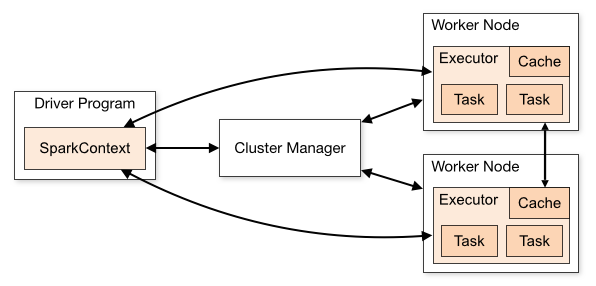

In [8]:
sc.getConf().getAll()

[('spark.app.id', 'local-1604197983942'),
 ('spark.driver.port', '54972'),
 ('spark.app.name', 'shparkley_example'),
 ('spark.driver.host', '192.168.1.6'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [9]:
sc.defaultParallelism, sc.defaultMinPartitions

(8, 2)

This means that by default, `pyspark.DataFrame`s will be created with 12 partitions. 

This is because `sc.parallelize` [here (link)](https://github.com/apache/spark/blob/97605cd1269987ed5ba3013a5f8497375ce8913e/python/pyspark/sql/session.py#L452) is used to convert from local-memory `DataFrame` which uses its `defaultParallelism`. 

There is [no obvious way](https://stackoverflow.com/a/28793407/588437) to get the number of [**executors**](https://spark.apache.org/docs/latest/cluster-overview.html) from the `pyspark` API. 


# Generate Example Dataset
We generate an example loan repayment dataset based on the simplistic assumption that whether a user repays is defined according to a simple tree with three features. 

## Create Ground Truth Tree

In [10]:
class Criterion:
    """
    Stores a lambda function of the form lambda x: x <operator> c 
    """
    def __init__(self, cutoff: Number, comparison_operator: str):
        self.cutoff = cutoff
        self.comparison_operator = comparison_operator    
    
    def __str__(self):
        """
        Just show the criterion, assuming a lambda function
        """
        return (f'{self.comparison_operator} {self.cutoff}')

    def __repr__(self):
        return self.__str__()

In [11]:
str(Criterion(comparison_operator='<=', cutoff=700))

'<= 700'

In [12]:
graph = nx.DiGraph()
graph.add_edge(
    "fico", "loan_amount", criterion=Criterion(comparison_operator="<=", cutoff=700)
)
graph.add_edge(
    "fico", "leaf_1", criterion=Criterion(comparison_operator=">", cutoff=700)
)
graph.add_edge(
    "loan_amount", "leaf_2", criterion=Criterion(comparison_operator="<=", cutoff=1000)
)
graph.add_edge(
    "loan_amount",
    "number_of_delinquencies",
    criterion=Criterion(comparison_operator=">", cutoff=1000),
)
graph.add_edge(
    "number_of_delinquencies",
    "leaf_3",
    criterion=Criterion(comparison_operator="<=", cutoff=0),
)
graph.add_edge(
    "number_of_delinquencies",
    "leaf_4",
    criterion=Criterion(comparison_operator=">", cutoff=0),
)


graph.nodes["leaf_1"]["p_delinquency"] = 0.01
graph.nodes["leaf_2"]["p_delinquency"] = 0.05
graph.nodes["leaf_3"]["p_delinquency"] = 0.03
graph.nodes["leaf_4"]["p_delinquency"] = 0.20

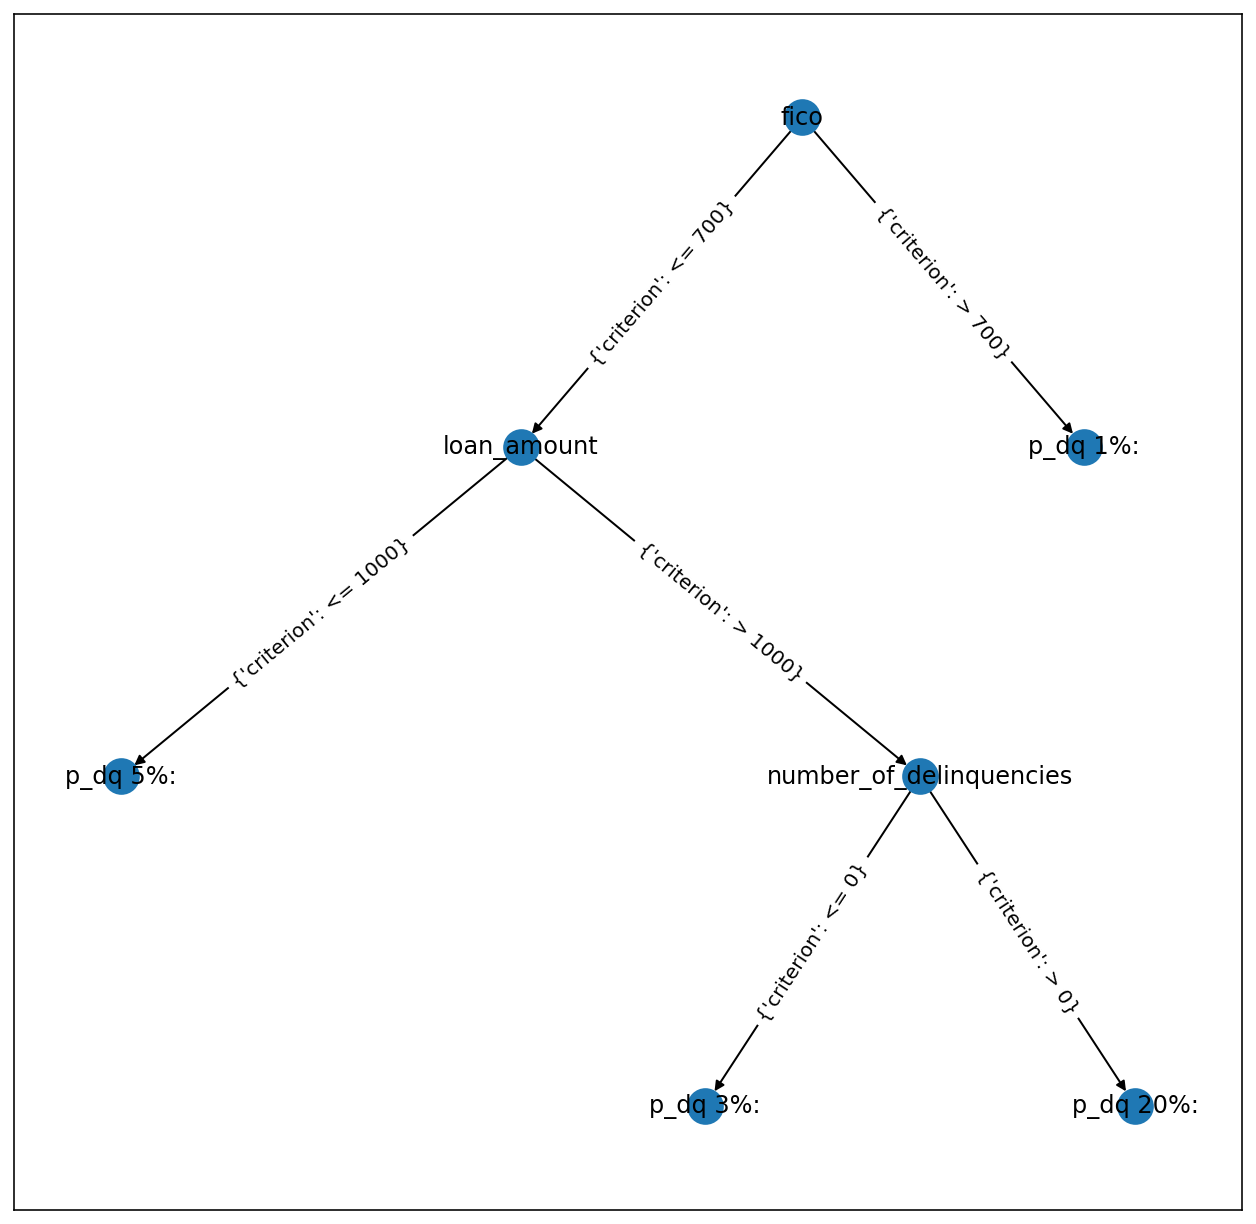

In [13]:
plt.figure(figsize=(11, 11))
labels = {
    k: "p_dq {0:.0f}%:".format(v.get("p_delinquency") * 100) if v else k
    for (k, v) in dict(graph.nodes).items()
}

positions = graphviz_layout(graph, prog="dot")
nx.draw_networkx(graph, positions, labels=labels)
_ = nx.draw_networkx_edge_labels(graph, positions)

## Generate from Tree
For each leaf node, generate data columns fitting the criteria and 1000 rows (Bernoulli with $p = $ `p_dq`)

In [14]:
def criteria_dict_to_row_values(
    criteria: Dict[str, Criterion], default_row_values: Dict[str, Number]
) -> Dict[str, Number]:
    """
    Given a dictionary with column_name -> Criteria mappinig, output what to set the feature row values to. 
    """
    output_row_values = default_row_values.copy()
    for column_name, criterion in criteria.items():
        if criterion.comparison_operator == "<=":
            output_row_values.update(
                {column_name: criterion.cutoff}
            )  # set feature value to exactly the cutoff if <=
        elif criterion.comparison_operator == ">":
            output_row_values.update(
                {column_name: criterion.cutoff + 1}
            )  # set feature value to cutoff + 1  if >
        else:
            raise ValueError(f"Unsupported {criterion.comparison_operator}")

    return output_row_values

In [15]:
def tree_to_leaf_row_values(
    tree: nx.DiGraph, row_value_fn: Callable, default_row_values: Dict[str, Number]
) -> Dict[str, Dict[str, Number]]:
    """
    Return, for list of leaf nodes, a dictionary mapping column name to value to generate. Note: not impleneted for recurring instances of the same feature along a single path to a leaf. 
    """
    leaf_row_values = {}
    # Get root name
    root_name = [n for (n, d) in tree.in_degree() if d == 0][0]
    # Get criteria for each leaf
    for node in tree:
        if tree.out_degree(node) == 0:  # leaf node
            criteria = {}
            for path in next(
                nx.all_simple_edge_paths(tree, root_name, node)
            ):  # only one path, so calling next() once gets it (math.stackexchange.com/a/1523566/440173)
                criteria[path[0]] = tree.edges[path]["criterion"]

            # Translate criteria to row value dict
            leaf_row_values[node] = row_value_fn(criteria, default_row_values)
            
    return leaf_row_values

In [16]:
DEFAULT_ROW_VALUES = {
    'fico': 350,
    'loan_amount': 1,
    'number_of_delinquencies': 0,
    'repaid_all_previous_affirm_loans': 0,
}

In [17]:
row_values_per_leaf = tree_to_leaf_row_values(
    tree=graph,
    row_value_fn=criteria_dict_to_row_values,
    default_row_values=DEFAULT_ROW_VALUES,
)

In [18]:
row_values_per_leaf

{'leaf_1': {'fico': 701,
  'loan_amount': 1,
  'number_of_delinquencies': 0,
  'repaid_all_previous_affirm_loans': 0},
 'leaf_2': {'fico': 700,
  'loan_amount': 1000,
  'number_of_delinquencies': 0,
  'repaid_all_previous_affirm_loans': 0},
 'leaf_3': {'fico': 700,
  'loan_amount': 1001,
  'number_of_delinquencies': 0,
  'repaid_all_previous_affirm_loans': 0},
 'leaf_4': {'fico': 700,
  'loan_amount': 1001,
  'number_of_delinquencies': 1,
  'repaid_all_previous_affirm_loans': 0}}

In [19]:
def generate_rows_per_leaf(
    tree: nx.DiGraph, row_values_per_leaf: Dict[str, Dict[str, Number]], n_per_leaf=100
) -> pd.DataFrame:
    dfs = []
    for leaf_name, leaf_row_values in row_values_per_leaf.items():
        leaf_df = pd.DataFrame(
            columns=list(leaf_row_values.keys()) + ["delinquent_label"],
            index=range(n_per_leaf),
        )
        leaf_df.loc[range(n_per_leaf), leaf_row_values.keys()] = list(
            leaf_row_values.values()
        )

        # Sample based on p_deliquency
        leaf_df.loc[range(n_per_leaf), "delinquent_label"] = bernoulli.rvs(
            p=tree.nodes[leaf_name]["p_delinquency"], size=n_per_leaf, random_state=42
        )
        dfs.append(leaf_df)

    return pd.concat(dfs, ignore_index=True)

In [20]:
generated_loans_with_labels = generate_rows_per_leaf(graph, row_values_per_leaf, n_per_leaf=1000)

In [21]:
generated_loans_with_labels[list(DEFAULT_ROW_VALUES.keys())] = generated_loans_with_labels[list(DEFAULT_ROW_VALUES.keys())].apply(pd.to_numeric)

generated_loans_with_labels.loc[:, 'delinquent_label'] = generated_loans_with_labels['delinquent_label'].astype(int)

In [22]:
generated_loans_with_labels.sample(10, random_state=47)

,fico,loan_amount,number_of_delinquencies,repaid_all_previous_affirm_loans,delinquent_label
1568,700,1000,0,0,0
648,701,1,0,0,0
3616,700,1001,1,0,0
3695,700,1001,1,0,0
2207,700,1001,0,0,0
2759,700,1001,0,0,0
612,701,1,0,0,0
2596,700,1001,0,0,0
534,701,1,0,0,0
532,701,1,0,0,1


In [23]:
generated_loans_with_labels['delinquent_label'].value_counts()

0    3727
1     273
Name: delinquent_label, dtype: int64

In [24]:
generated_loans_with_labels.describe()

,fico,loan_amount,number_of_delinquencies,repaid_all_previous_affirm_loans,delinquent_label
count,4000.0000,4000.0000,4000.0000,4000.0,4000.0000
mean,700.2500,750.7500,0.2500,0.0,0.0683
std,0.4331,432.9227,0.4331,0.0,0.2522
min,700.0000,1.0000,0.0000,0.0,0.0000
25%,700.0000,750.2500,0.0000,0.0,0.0000
50%,700.0000,1000.5000,0.0000,0.0,0.0000
75%,700.2500,1001.0000,0.2500,0.0,0.0000
max,701.0000,1001.0000,1.0000,0.0,1.0000


In [25]:
generated_loans_with_labels.shape

(4000, 5)

# Fit Sample Model

In [26]:
N_ESTIMATORS = 3

## Add high weights to handle unbalanced DQ

In [27]:
generated_loans_with_labels.loc[:, "weight"] = np.where(
    generated_loans_with_labels["delinquent_label"] == True, 10.0, 1.0
)

In [28]:
np.random.seed(42)
train, test = train_test_split(generated_loans_with_labels)

In [29]:
train.shape, test.shape

((3000, 6), (1000, 6))

In [30]:
random_forest_classifier = RandomForestClassifier(n_estimators=N_ESTIMATORS)

In [31]:
np.random.seed(42)
fitted_model = random_forest_classifier.fit(
    X=train.drop(["delinquent_label", "weight"], axis=1),
    y=train["delinquent_label"],
    sample_weight=train["weight"],    
)

## Sanity-Check Fit

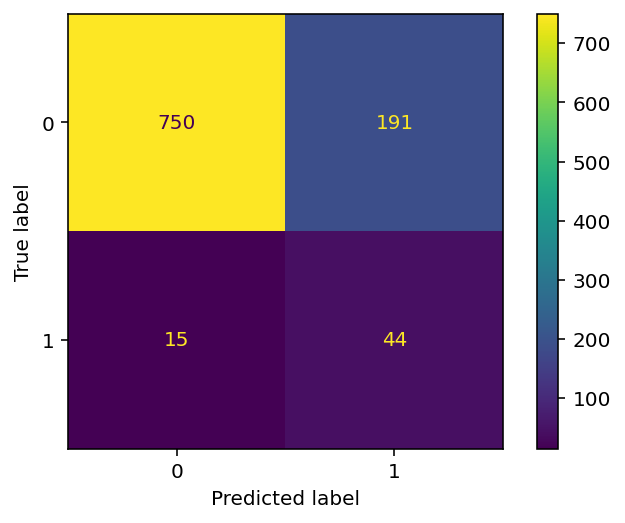

In [32]:
_ = plot_confusion_matrix(
    estimator=fitted_model,
    X=test.drop(["delinquent_label", "weight"], axis=1),
    y_true=test["delinquent_label"],
)

In [33]:
print(
    "Precision = {:.2f}, Recall = {:.2f}, F1 = {:.2f}".format(
        precision_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_model.predict(test.drop(["delinquent_label", "weight"], axis=1)),
        ),
        recall_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_model.predict(test.drop(["delinquent_label", "weight"], axis=1)),
        ),
        f1_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_model.predict(test.drop(["delinquent_label", "weight"], axis=1)),
        ),
    )
)

Precision = 0.19, Recall = 0.75, F1 = 0.30


When taking into account sample weights, confusion matrix looks much more reasonable. 

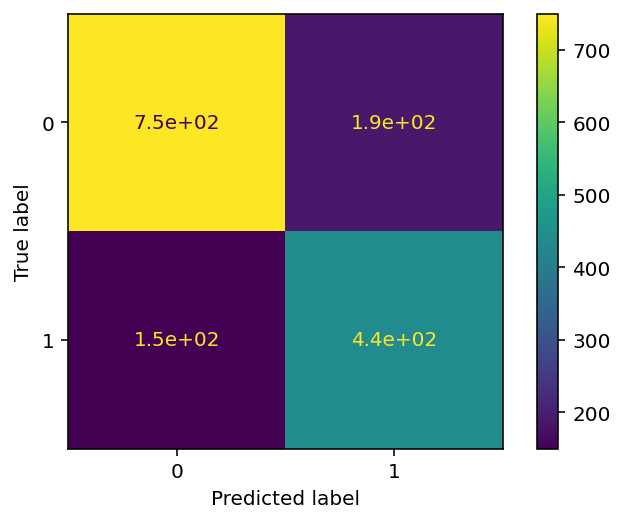

In [34]:
_ = plot_confusion_matrix(
    estimator=fitted_model,
    X=test.drop(["delinquent_label", "weight"], axis=1),
    y_true=test["delinquent_label"],
    sample_weight=test['weight'],
)

In [35]:
print(
    "Precision = {:.2f}, Recall = {:.2f}, F1 = {:.2f}".format(
        precision_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_model.predict(test.drop(["delinquent_label", "weight"], axis=1)),
            sample_weight=test['weight'],
        ),
        recall_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_model.predict(test.drop(["delinquent_label", "weight"], axis=1)),
            sample_weight=test['weight'],
        ),
        f1_score(
            y_true=test["delinquent_label"],
            y_pred=fitted_model.predict(test.drop(["delinquent_label", "weight"], axis=1)),
            sample_weight=test['weight'],
        ),
    )
)

Precision = 0.70, Recall = 0.75, F1 = 0.72


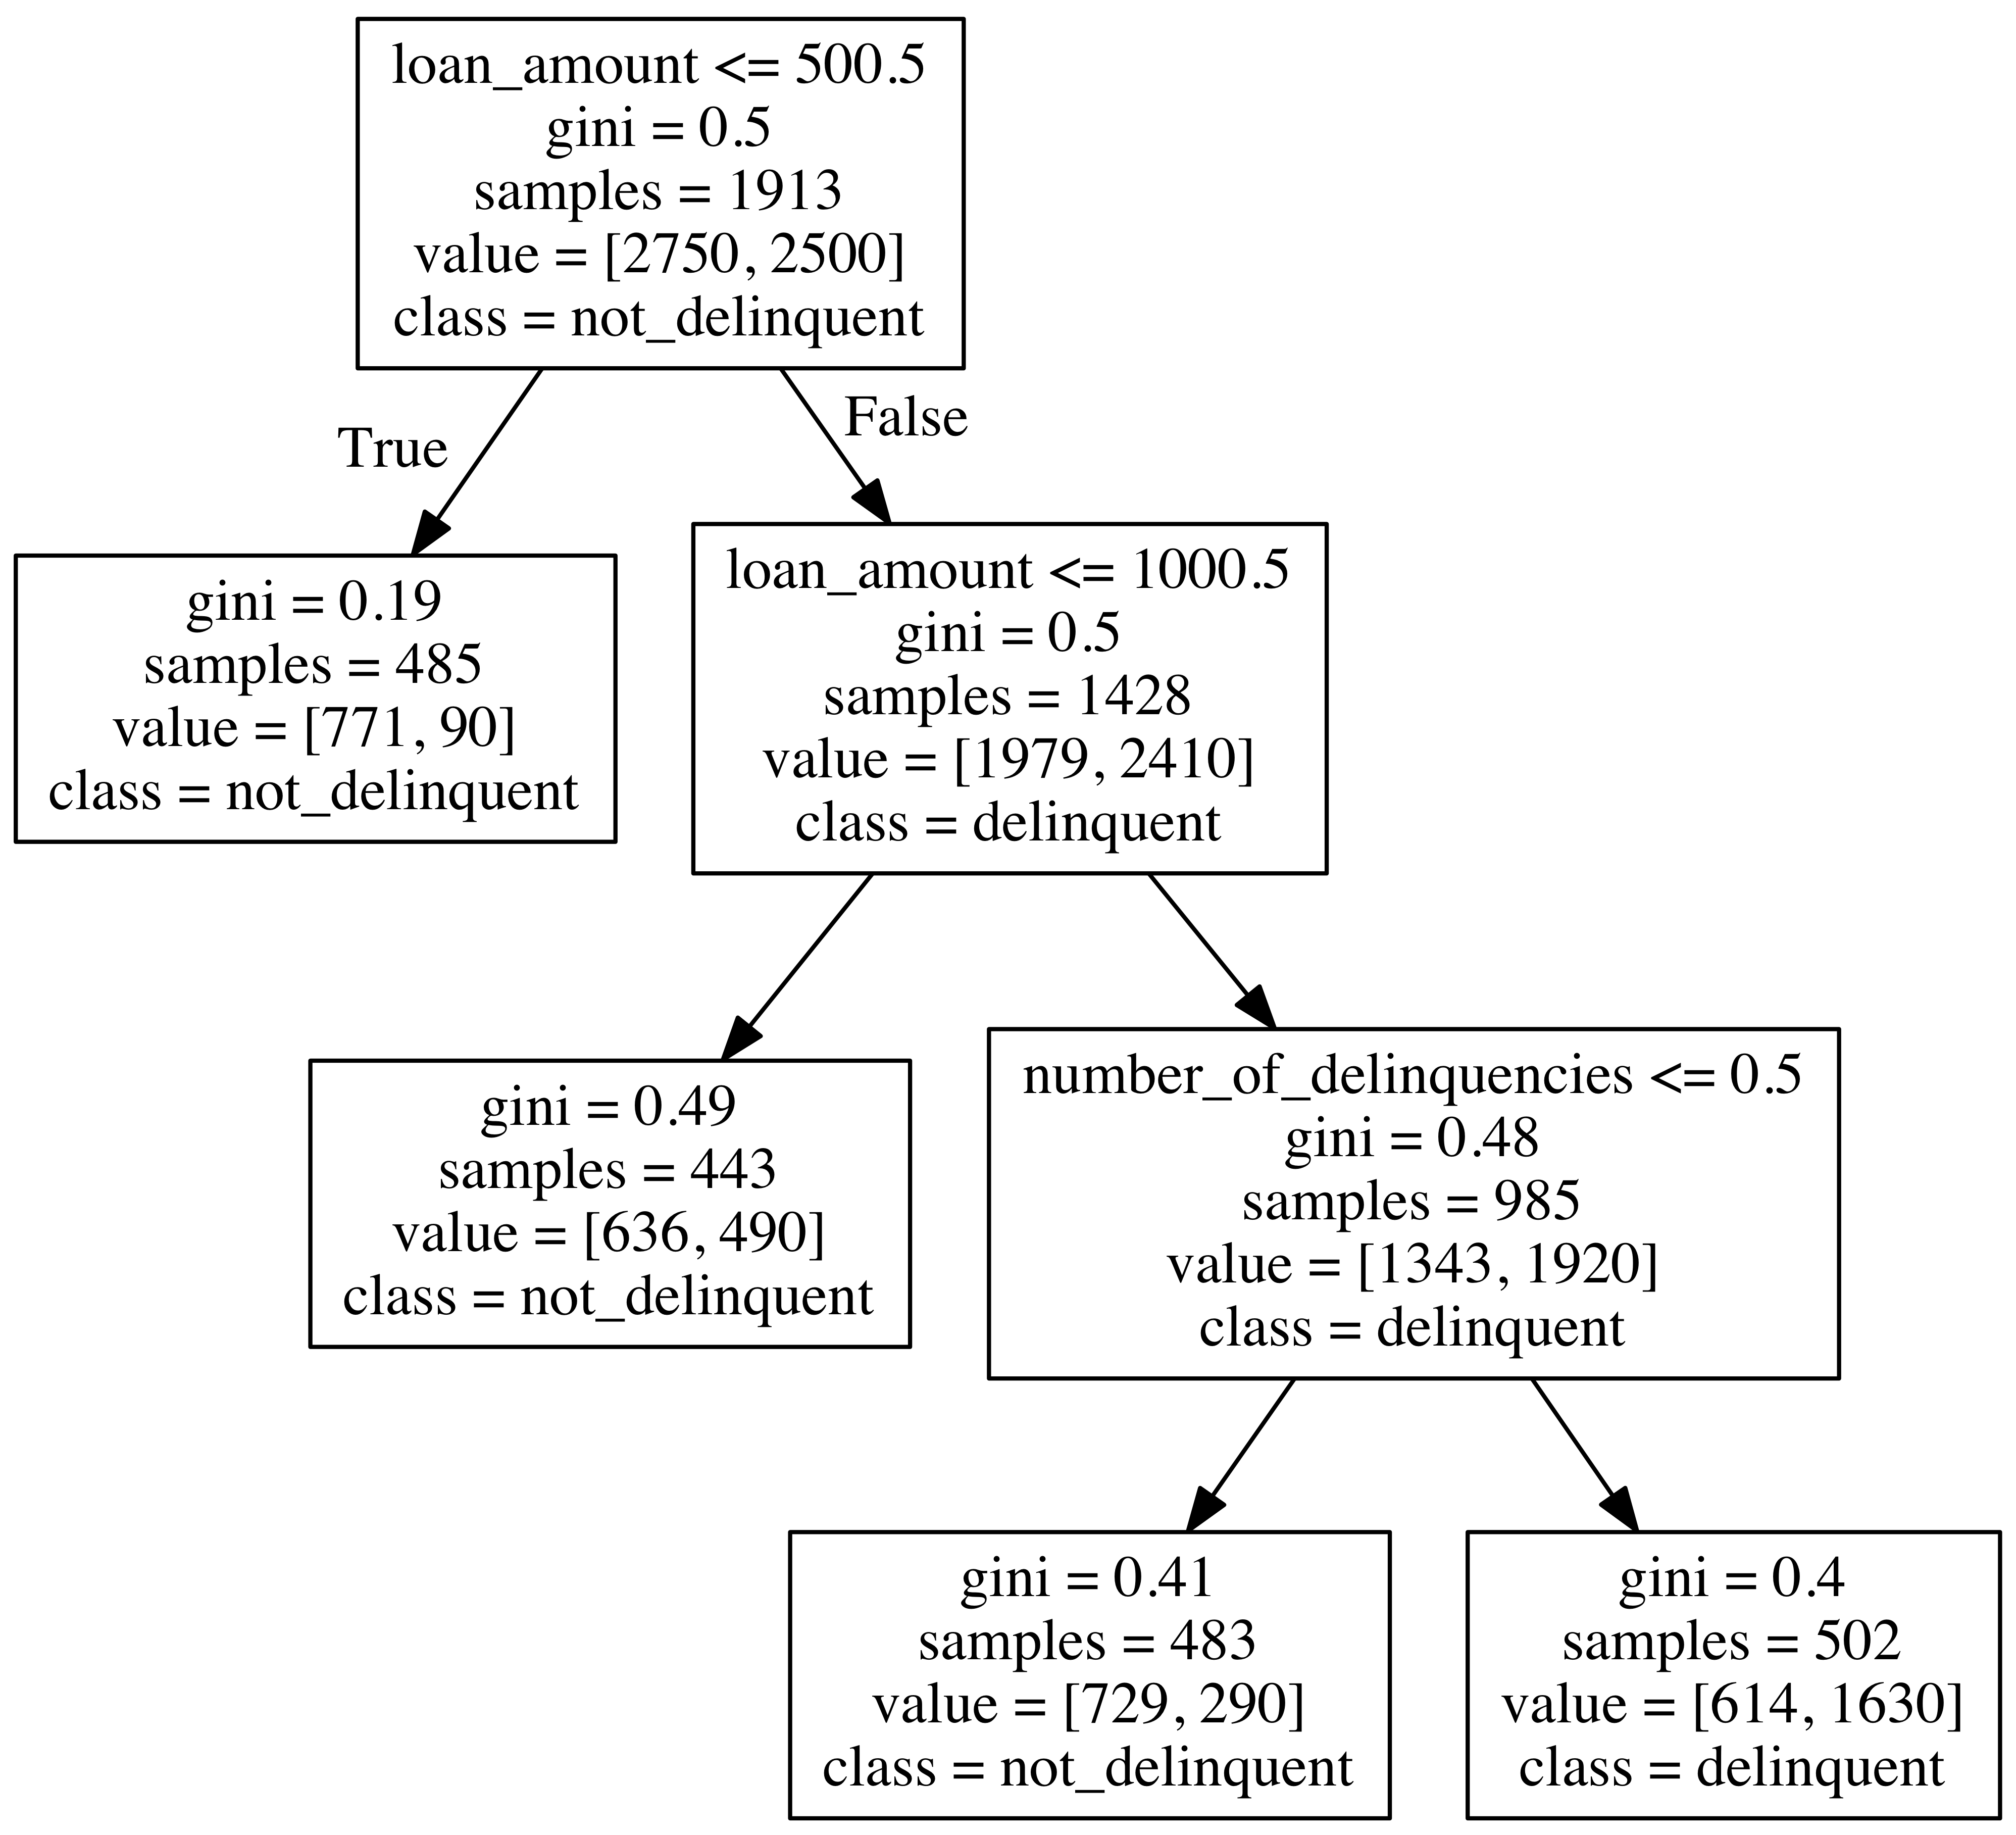

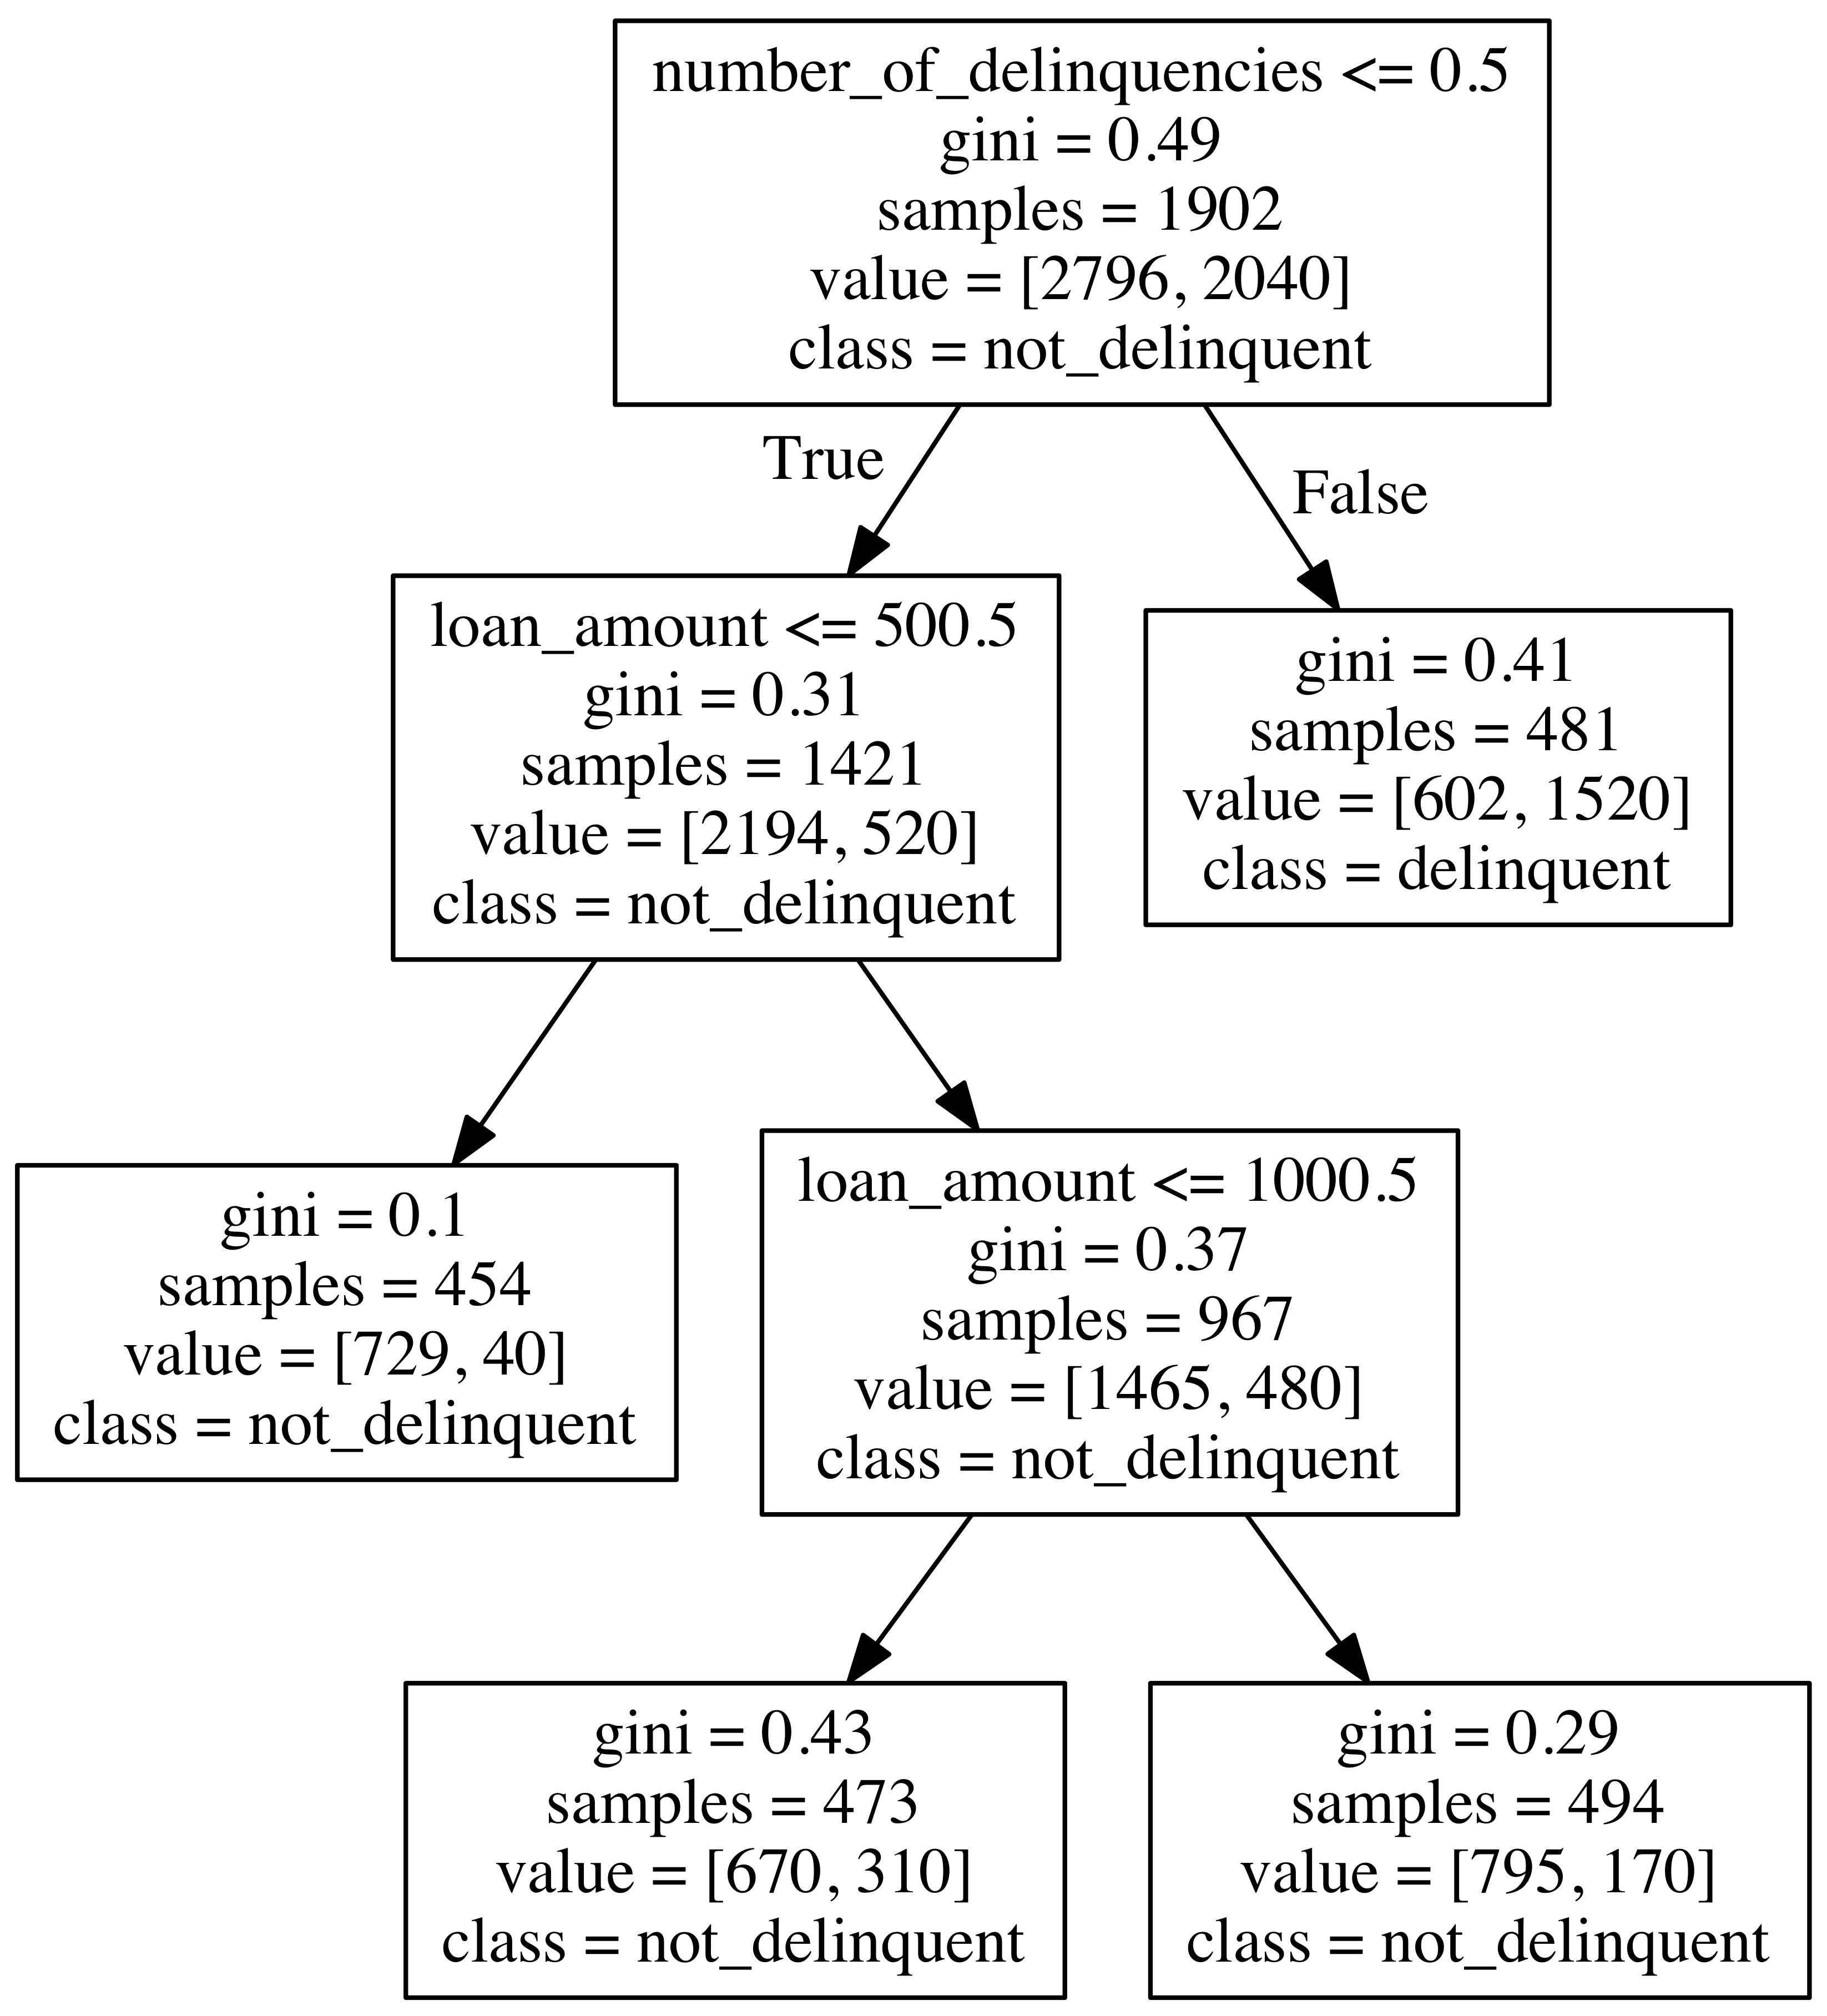

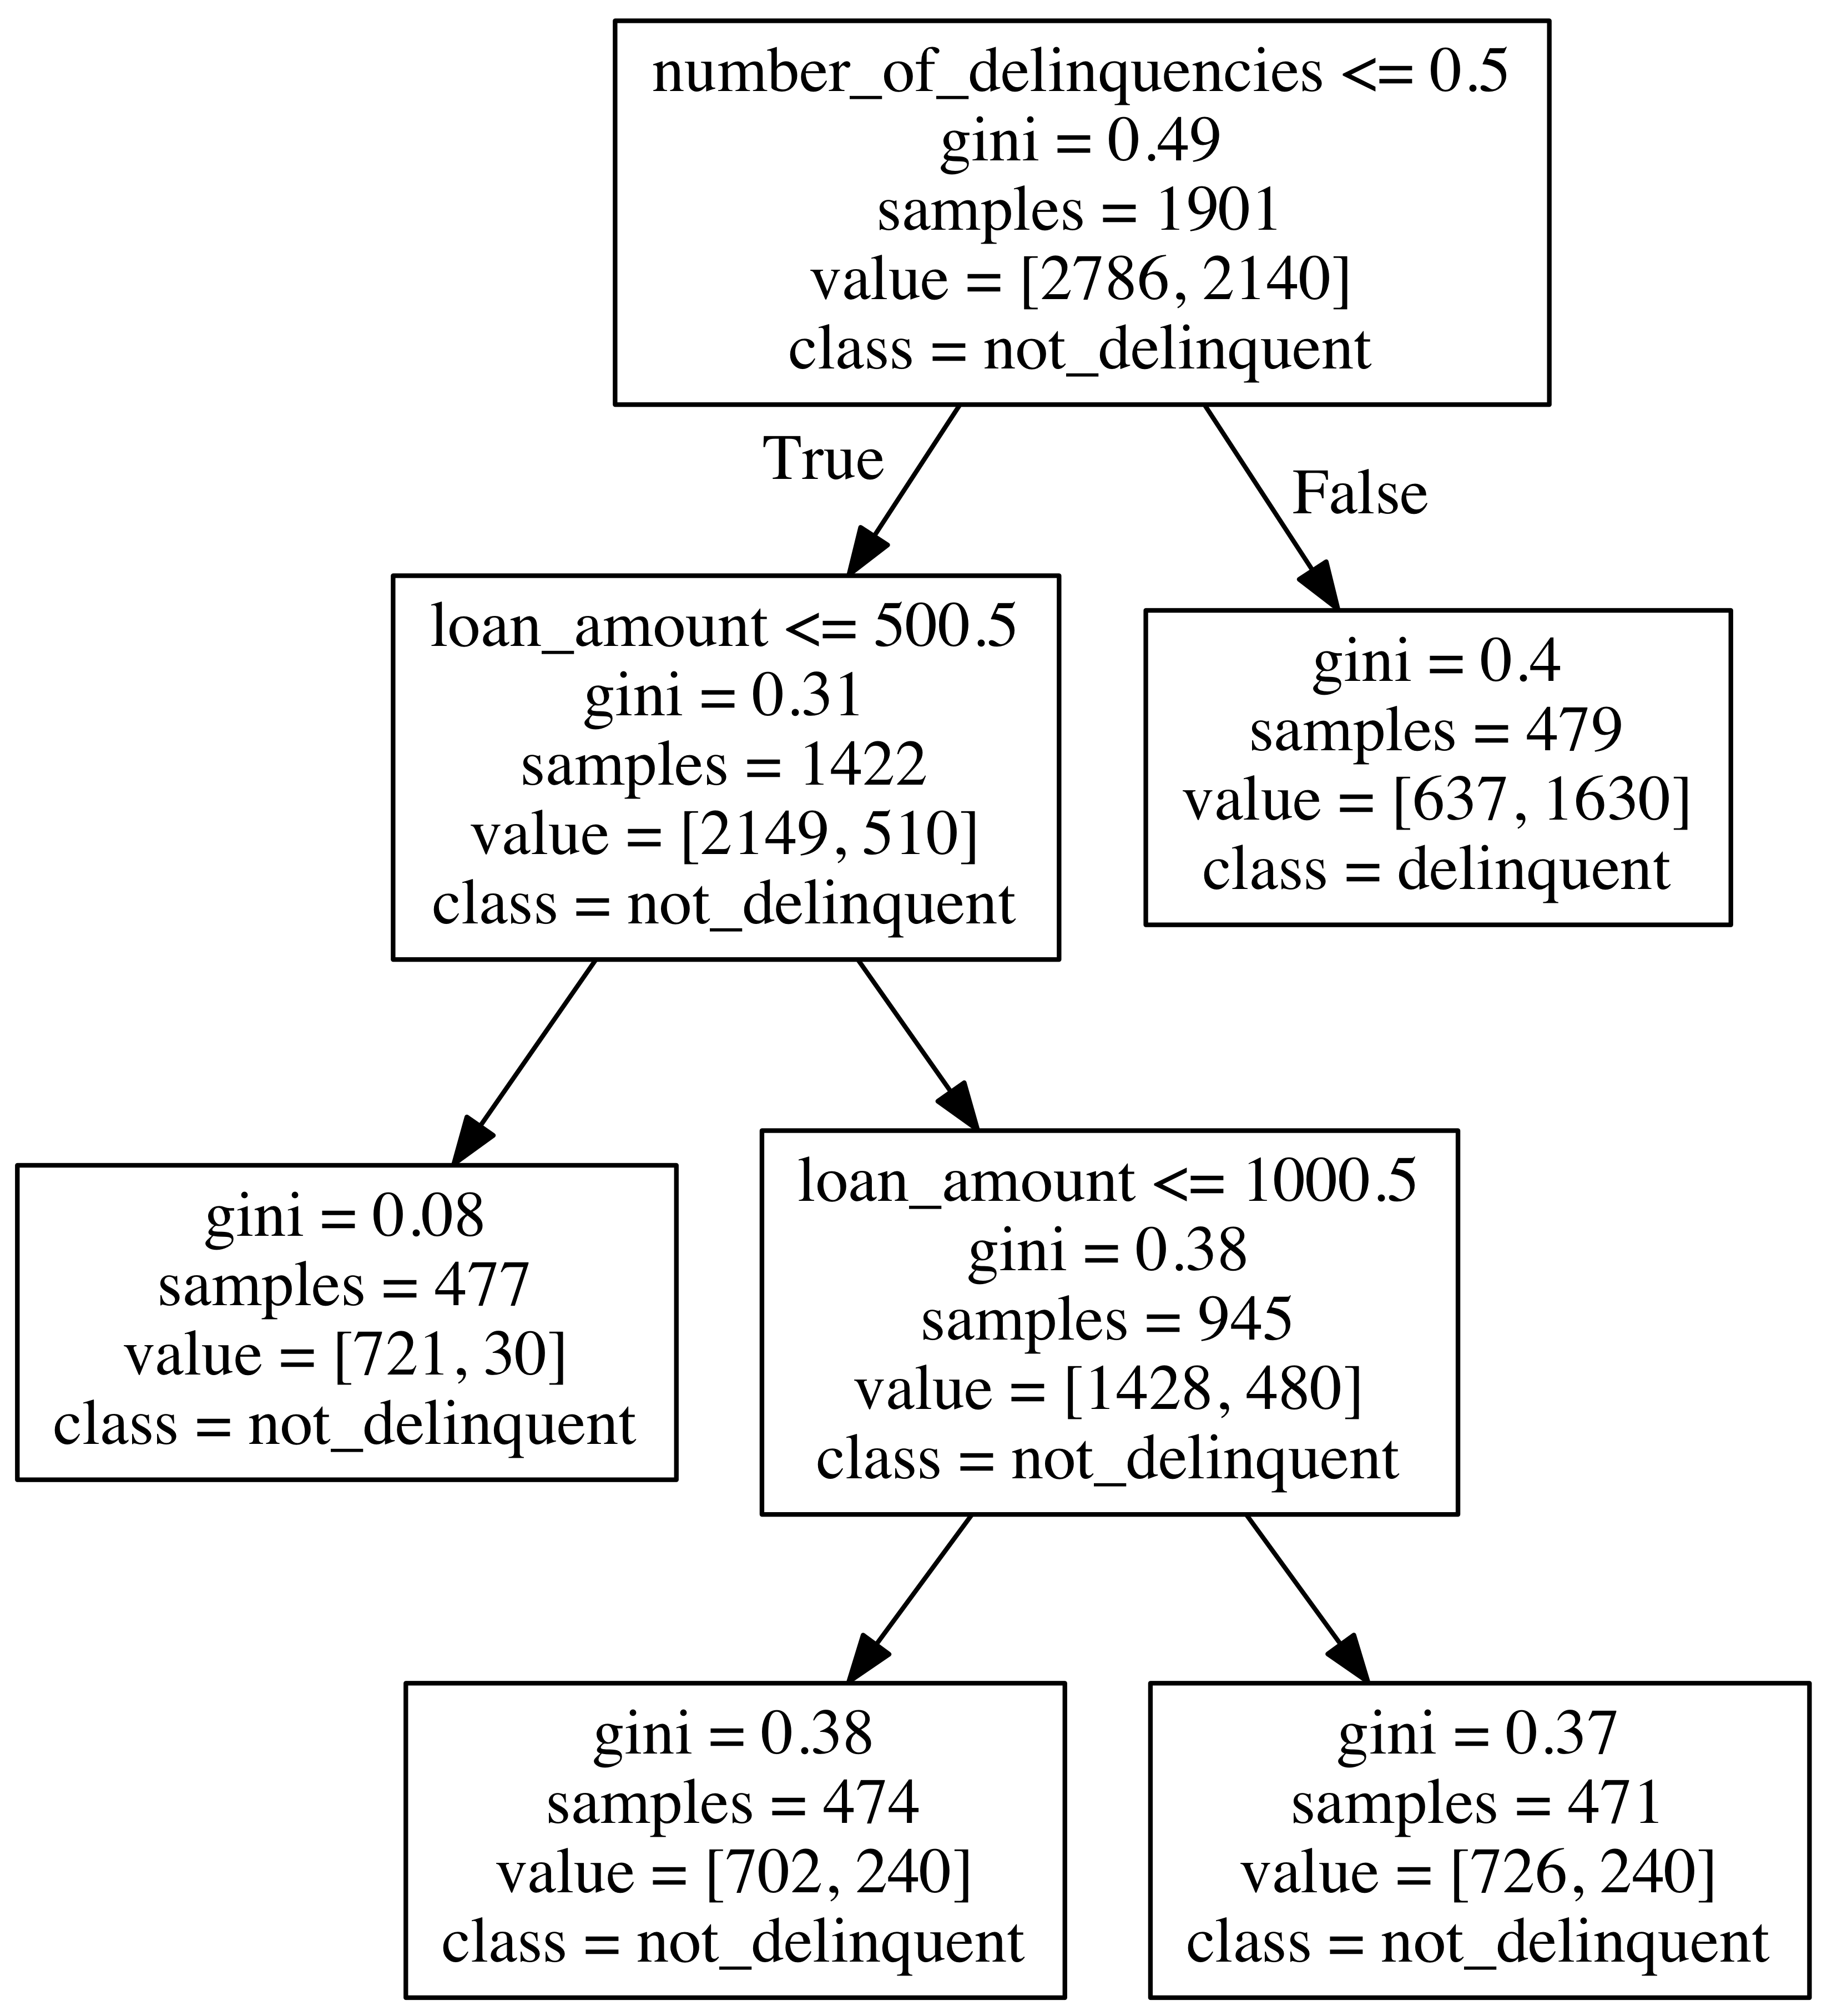

In [36]:
images = []
for estimator in fitted_model.estimators_:
    dot_file = mktemp(suffix='.dot')
    png_file = mktemp(suffix='.png')
    export_graphviz(estimator, out_file=dot_file, feature_names = generated_loans_with_labels.columns[:4], class_names=['not_delinquent', 'delinquent'], precision=2)
    system(f'dot -Tpng {dot_file} -o {png_file} -Gdpi=600')
    images.append(Image(png_file, width=300))

display(*images)

# Explain with Spark + Shapley

Create wrapper class. Note that within `predict`, we _cannot_ create a new distributed in-memory dataset, as this needs to be executed locally to the executor. This is a minor restriction as most models have relatively-fast inferencing, and also opens us up to use spark to accelerate the Shapley algorithm on a wide variety of existing models rather than `pyspark.mllib` and `pyspark.ml` models. If needed, spark models can be converted using [ONNX](https://github.com/onnx/onnxmltools) or similar to a model which can predict on a local executor. 

## Prep: Wrapper API

In [37]:
class MyShparkleyModel(ShparkleyModel):
    def __init__(self, model: ClassifierMixin, required_features: Set[str]):
        self._model = model
        self._required_features = set(required_features)

    def predict(self, feature_matrix: List[Dict[str, Any]]) -> List[float]:
        pd_df = pd.DataFrame.from_dict(feature_matrix)
        preds = self._model.predict_proba(pd_df)[:, 1]
        return preds

    def get_required_features(self) -> Set[str]:
        return self._required_features

In [38]:
model_with_shparkley_interface = MyShparkleyModel(
    model=fitted_model, required_features=generated_loans_with_labels.columns[:4]
)

In [39]:
model_with_shparkley_interface.get_required_features()

{'fico',
 'loan_amount',
 'number_of_delinquencies',
 'repaid_all_previous_affirm_loans'}

## Explain Some Test Datapoints

### Load Training DataFrame into Spark

In [40]:
sql_context = SQLContext(sc)

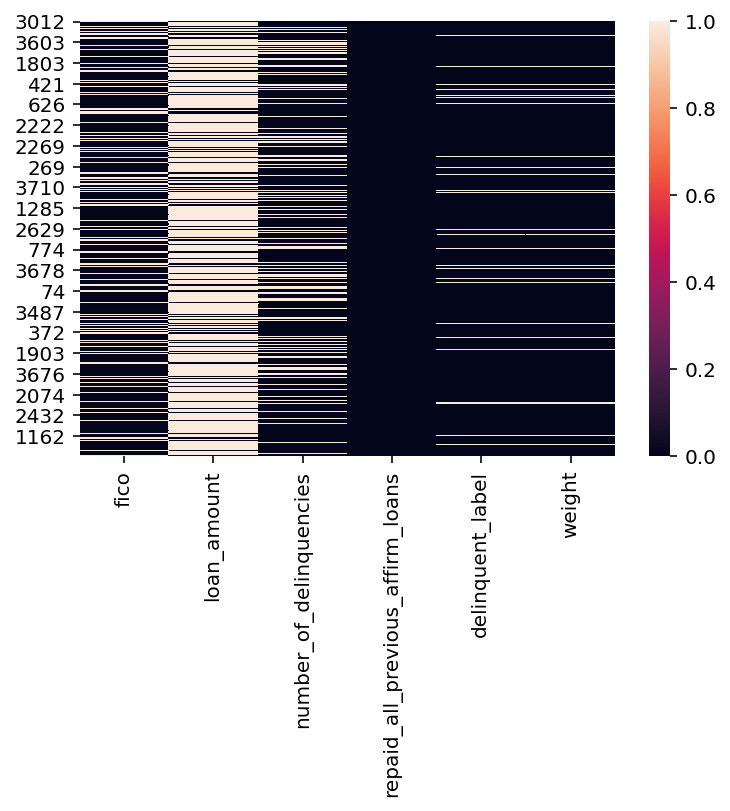

In [41]:
from sklearn.preprocessing import minmax_scale
_ = sns.heatmap(pd.DataFrame(minmax_scale(train), columns=train.columns, index=train.index))

In [42]:
train = train.sample(frac=1, replace=False)

In [43]:
train_spark_df = sql_context.createDataFrame(train)

In [44]:
train_spark_df.rdd.getNumPartitions()

8

Twelve, as foreshadowed by earlier `defaultParallelism`

### Explain an Example Row

In [45]:
query_row = Row(fico=600, loan_amount=300, number_of_delinquencies=1, repaid_all_previous_affirm_loans=0)
query_row_df = pd.DataFrame(query_row.asDict(), index=[0])
query_row

Row(fico=600, loan_amount=300, number_of_delinquencies=1, repaid_all_previous_affirm_loans=0)

In [46]:
fitted_model.predict_proba(query_row_df)[0][1]

0.5132822996760881

This is predicted to be slightly more likely delinquent than not. Why is this different from the average prediction in the training set, which is just 7% delinquent? 

In [47]:
compute_shapley_for_sample(
    df=train_spark_df,
    model=model_with_shparkley_interface,
    row_to_investigate=query_row,
)

{'fico': 0.0,
 'number_of_delinquencies': 0.0,
 'loan_amount': 0.0,
 'repaid_all_previous_affirm_loans': 0.0}

Interesting. Number of historical delinquencies. Nothing much else is important. As we might expect from our tree construction above. 

In [48]:
train['delinquent_label'].mean()

0.07133333333333333

### Explain, Taking Weights into Account

In [49]:
compute_shapley_for_sample(
    df=train_spark_df,
    model=model_with_shparkley_interface,
    row_to_investigate=query_row,
    weight_col_name='weight',
)

{'fico': 0.0,
 'number_of_delinquencies': 0.0,
 'loan_amount': 0.0,
 'repaid_all_previous_affirm_loans': 0.0}

In [50]:
np.average(train['delinquent_label'], weights=train['weight'])

0.4344295574502639

DQs are weighted higher, so this makes sense. 

# Compare to `shap`

In [58]:
import shap

In [59]:
shap_explainer = shap.KernelExplainer(lambda x: fitted_model.predict_proba(x)[:, 1], train.drop(['weight', 'delinquent_label'], axis=1))

Using 3000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [60]:
shap_values = shap_explainer.shap_values(X=query_row_df, check_additivity=True)
shap_values

array([[ 0.        , -0.14777224,  0.31842391,  0.        ]])

In [63]:
shap.initjs()

In [64]:
shap.force_plot(base_value=shap_explainer.expected_value, shap_values=shap_values[0], features=query_row_df)

Ok, this looks reasonable. 